# Battery Aging Patterns

### Load, prepare the data + EDA

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("patrickfleith/nasa-battery-dataset")

print("Path to dataset files:", path)

100%|██████████| 228M/228M [00:28<00:00, 8.34MB/s] 

Extracting files...


Path to dataset files: C:\Users\ilvir\.cache\kagglehub\datasets\patrickfleith\nasa-battery-dataset\versions\2


In [1]:
import numpy as np
import pandas as pd
import glob
import scipy.stats as stats
from scipy.stats import norm, permutation_test
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load metadata to find impedance files
metadata_path = r"C:\Users\ilvir\.cache\kagglehub\datasets\patrickfleith\nasa-battery-dataset\versions\2\cleaned_dataset\metadata.csv"
metadata = pd.read_csv(metadata_path)

# Filter rows where type is "impedance"
impedance_files = metadata[metadata["type"] == "impedance"]["filename"].tolist()

# Load all impedance CSVs into a single DataFrame
data_path = r"C:\Users\ilvir\.cache\kagglehub\datasets\patrickfleith\nasa-battery-dataset\versions\2\cleaned_dataset\data"
impedance_dfs = []

for file in impedance_files:
    df = pd.read_csv(f"{data_path}/{file}")
    df["filename"] = file  # Track source file
    impedance_dfs.append(df)

impedance_data = pd.concat(impedance_dfs, ignore_index=True)

In [4]:
impedance_data.head()

,Sense_current,Battery_current,Current_ratio,Battery_impedance,Rectified_Impedance,filename
0,(928.3472290039062-48.499576568603516j),(228.7861328125-70.94481658935547j),(3.76172584438583+0.9544956717274271j),(0.19021741554080737+0.07913959666077047j),(0.17493022756754967-0.02331644173631698j),00002.csv
1,(922.0059814453125-52.15481185913086j),(233.29783630371094-67.84492492675781j),(3.70383574337748+0.8535511912426126j),(0.012482111540534805+0.03664975726191017j),(0.16866854345060991-0.024717137242854174j),00002.csv
2,(920.0405883789062-52.19926452636719j),(236.62075805664062-67.22105407714844j),(3.6558702379340415+0.8179848126025503j),(0.030461237041852884-0.08529386061204824j),(0.16107808875912483-0.024114907529065532j),00002.csv
3,(914.2005615234375-52.371726989746094j),(242.2973175048828-66.45936584472656j),(3.564190338159781+0.7614698525522733j),(0.14229365598447172-0.12192216177062407j),(0.14924381603096853-0.02372905366581296j),00002.csv
4,(911.2781372070312-45.477928161621094j),(246.62347412109375-65.4150161743164j),(3.4978434135716947+0.7433743116536402j),(0.24388219819020493-0.08033187245076714j),(0.14049811021506395-0.022851601640846698j),00002.csv


In [6]:
# Extract metadata columns to merge
metadata_cols = ["filename", "ambient_temperature", "battery_id", "test_id", "Re", "Rct"]
impedance_metadata = metadata[metadata["type"] == "impedance"][metadata_cols]

# Merge with impedance data
impedance_data = pd.merge(
    impedance_data,
    impedance_metadata,
    on="filename",
    how="left"
)

impedance_data.head()

,Sense_current,Battery_current,Current_ratio,Battery_impedance,Rectified_Impedance,filename,ambient_temperature,battery_id,test_id,Re,Rct
0,(928.3472290039062-48.499576568603516j),(228.7861328125-70.94481658935547j),(3.76172584438583+0.9544956717274271j),(0.19021741554080737+0.07913959666077047j),(0.17493022756754967-0.02331644173631698j),00002.csv,24,B0047,1,0.05605783343888099,0.20097016584458333
1,(922.0059814453125-52.15481185913086j),(233.29783630371094-67.84492492675781j),(3.70383574337748+0.8535511912426126j),(0.012482111540534805+0.03664975726191017j),(0.16866854345060991-0.024717137242854174j),00002.csv,24,B0047,1,0.05605783343888099,0.20097016584458333
2,(920.0405883789062-52.19926452636719j),(236.62075805664062-67.22105407714844j),(3.6558702379340415+0.8179848126025503j),(0.030461237041852884-0.08529386061204824j),(0.16107808875912483-0.024114907529065532j),00002.csv,24,B0047,1,0.05605783343888099,0.20097016584458333
3,(914.2005615234375-52.371726989746094j),(242.2973175048828-66.45936584472656j),(3.564190338159781+0.7614698525522733j),(0.14229365598447172-0.12192216177062407j),(0.14924381603096853-0.02372905366581296j),00002.csv,24,B0047,1,0.05605783343888099,0.20097016584458333
4,(911.2781372070312-45.477928161621094j),(246.62347412109375-65.4150161743164j),(3.4978434135716947+0.7433743116536402j),(0.24388219819020493-0.08033187245076714j),(0.14049811021506395-0.022851601640846698j),00002.csv,24,B0047,1,0.05605783343888099,0.20097016584458333


In [7]:
# Display basic info
print("Dataset Shape:", impedance_data.shape)
print("\nColumns:", impedance_data.columns.tolist())
print("\nMissing Values:\n", impedance_data.isnull().sum())


Dataset Shape: (93888, 11)

Columns: ['Sense_current', 'Battery_current', 'Current_ratio', 'Battery_impedance', 'Rectified_Impedance', 'filename', 'ambient_temperature', 'battery_id', 'test_id', 'Re', 'Rct']

Missing Values:
 Sense_current              0
Battery_current            0
Current_ratio              0
Battery_impedance          0
Rectified_Impedance    17604
filename                   0
ambient_temperature        0
battery_id                 0
test_id                    0
Re                         0
Rct                        0
dtype: int64


In [8]:
# Drop rows with missing Rectified_Impedance
impedance_data = impedance_data.dropna(subset=['Rectified_Impedance'])

In [9]:
# Print number of unique values for key columns
print("Number of unique ambient_temperature values:", impedance_data["ambient_temperature"].nunique())
print("Number of unique battery_id values:", impedance_data["battery_id"].nunique())
print("Number of unique test_id (cycle) values:", impedance_data["test_id"].nunique())

Number of unique ambient_temperature values: 2
Number of unique battery_id values: 34
Number of unique test_id (cycle) values: 431


In [10]:
print("Unique temperatures:", impedance_data['ambient_temperature'].unique())

Unique temperatures: [24 43]


#### Extract Magnitudes from Complex Numbers

In [12]:
def parse_complex_to_magnitude(x):
    try:
        if isinstance(x, str) and '(' in x:  # Complex number (e.g., "(a-bj)")
            x = x.strip('()').replace('j', '')
            # Handle both "+" and "-" between real/imaginary parts
            if '+' in x:
                real, imag = x.split('+')
            elif '-' in x[1:]:  # Skip first character (could be negative real part)
                parts = x.split('-', 1)  # Split on first "-" only
                real = parts[0]
                imag = '-' + parts[1]  # Re-add "-" to imaginary part
            else:
                real, imag = x, '0'  # No imaginary part
            return np.sqrt(float(real)**2 + float(imag)**2)
        else:  # Real number (e.g., 0.056)
            return float(x)
    except:
        return np.nan  # Skip problematic values

# Apply to complex columns
complex_cols = [
    "Sense_current", "Battery_current", "Current_ratio",
    "Battery_impedance", "Rectified_Impedance", "Re", "Rct"
]
for col in complex_cols:
    impedance_data[col + "_mag"] = impedance_data[col].apply(parse_complex_to_magnitude)

# Drop rows with NaN magnitudes (if any)
impedance_data = impedance_data.dropna(subset=[col + "_mag" for col in complex_cols])

# Drop original complex columns 
impedance_data = impedance_data.drop(columns=complex_cols)

In [13]:
impedance_data.head(10)

,filename,ambient_temperature,battery_id,test_id,Sense_current_mag,Battery_current_mag,Current_ratio_mag,Battery_impedance_mag,Rectified_Impedance_mag,Re_mag,Rct_mag
0,00002.csv,24,B0047,1,929.613246,239.533425,3.880933,0.206024,0.176477,0.056058,0.20097
1,00002.csv,24,B0047,1,923.479915,242.962578,3.800914,0.038717,0.170470,0.056058,0.20097
2,00002.csv,24,B0047,1,921.520183,245.983848,3.746263,0.090570,0.162873,0.056058,0.20097
3,00002.csv,24,B0047,1,915.699440,251.246567,3.644625,0.187383,0.151118,0.056058,0.20097
4,00002.csv,24,B0047,1,912.412234,255.151450,3.575963,0.256772,0.142344,0.056058,0.20097
5,00002.csv,24,B0047,1,908.299021,259.566050,3.499298,0.303309,0.133060,0.056058,0.20097
6,00002.csv,24,B0047,1,900.584496,267.648148,3.364808,0.331113,0.124583,0.056058,0.20097
7,00002.csv,24,B0047,1,892.252368,275.154711,3.242730,0.343871,0.114812,0.056058,0.20097
8,00002.csv,24,B0047,1,886.311340,282.067279,3.142198,0.344856,0.109269,0.056058,0.20097
9,00002.csv,24,B0047,1,878.465942,289.249132,3.037056,0.336951,0.101248,0.056058,0.20097


In [14]:
print("Dataset Shape:", impedance_data.shape)
print("\nMissing Values:\n", impedance_data.isnull().sum())

Dataset Shape: (75597, 11)

Missing Values:
 filename                   0
ambient_temperature        0
battery_id                 0
test_id                    0
Sense_current_mag          0
Battery_current_mag        0
Current_ratio_mag          0
Battery_impedance_mag      0
Rectified_Impedance_mag    0
Re_mag                     0
Rct_mag                    0
dtype: int64


#### Plot histograms, check variances

In [24]:
# Group by battery and temperature, then calculate variance
variances = (impedance_data.groupby(['battery_id', 'ambient_temperature'])
               [['Re_mag', 'Rct_mag']]
               .var()
               .reset_index())

print(variances)

   battery_id  ambient_temperature        Re_mag       Rct_mag
0       B0005                   24  2.992701e-05  4.037114e-05
1       B0006                   24  2.399458e-05  5.421427e-05
2       B0007                   24  6.295326e-05  7.051842e-05
3       B0018                   24  3.090556e-06  1.252401e-05
4       B0025                   24  1.084627e-06  7.961321e-05
5       B0026                   24  7.265845e-07  5.328603e-05
6       B0027                   24  2.109469e-05  5.225840e-05
7       B0028                   24  8.944775e-07  7.912194e-05
8       B0029                   43  2.159786e-07  1.267824e-06
9       B0030                   43  2.661099e-07  5.996619e-07
10      B0031                   43  4.008047e-07  8.963015e-07
11      B0032                   43  1.638776e-06  3.580885e-06
12      B0033                   24  1.947447e-04  2.474367e-04
13      B0034                   24  6.257694e-06  1.319045e-05
14      B0036                   24  1.328977e-06  1.158

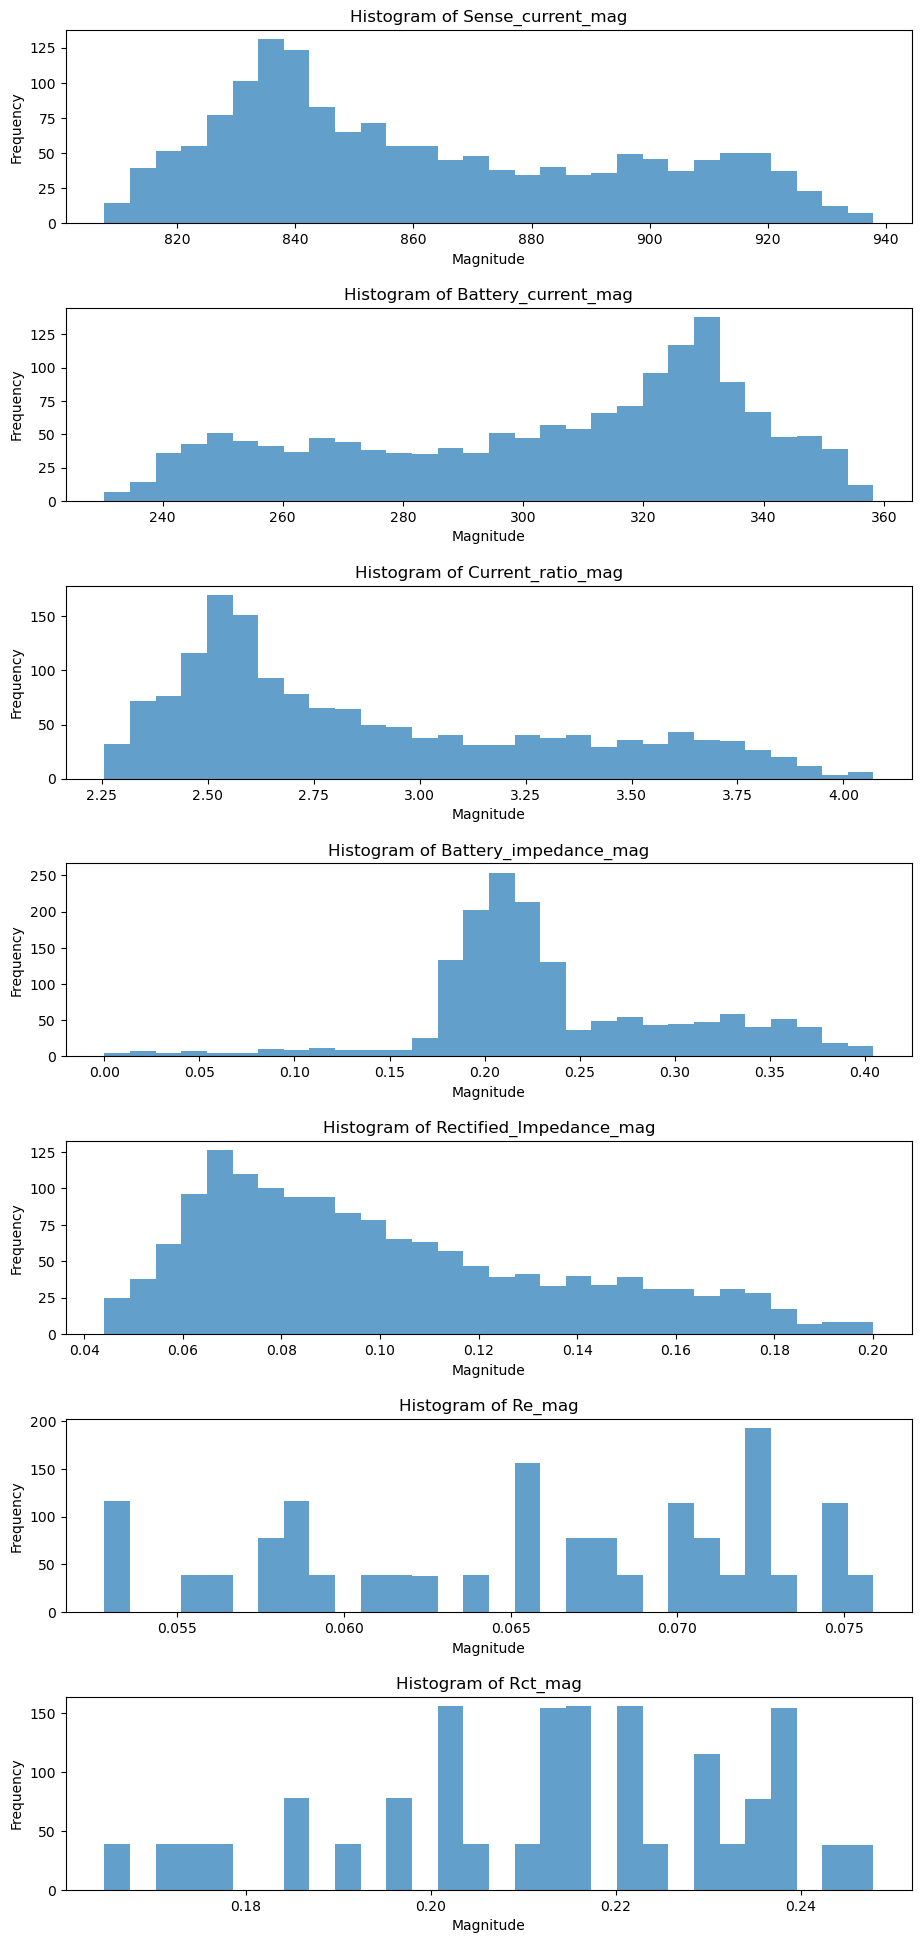

In [25]:
# Filter data for battery B0047
battery_data = impedance_data[impedance_data['battery_id'] == 'B0047']

# List of magnitude columns to plot
mag_columns = [
    'Sense_current_mag', 
    'Battery_current_mag',
    'Current_ratio_mag',
    'Battery_impedance_mag',
    'Rectified_Impedance_mag',
    'Re_mag',
    'Rct_mag'
]

# Create subplots
fig, axes = plt.subplots(nrows=len(mag_columns), ncols=1, figsize=(10, 20))
fig.tight_layout(pad=4.0)

# Plot histograms
for ax, col in zip(axes, mag_columns):
    ax.hist(battery_data[col], bins=30, alpha=0.7)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Frequency')

plt.show()

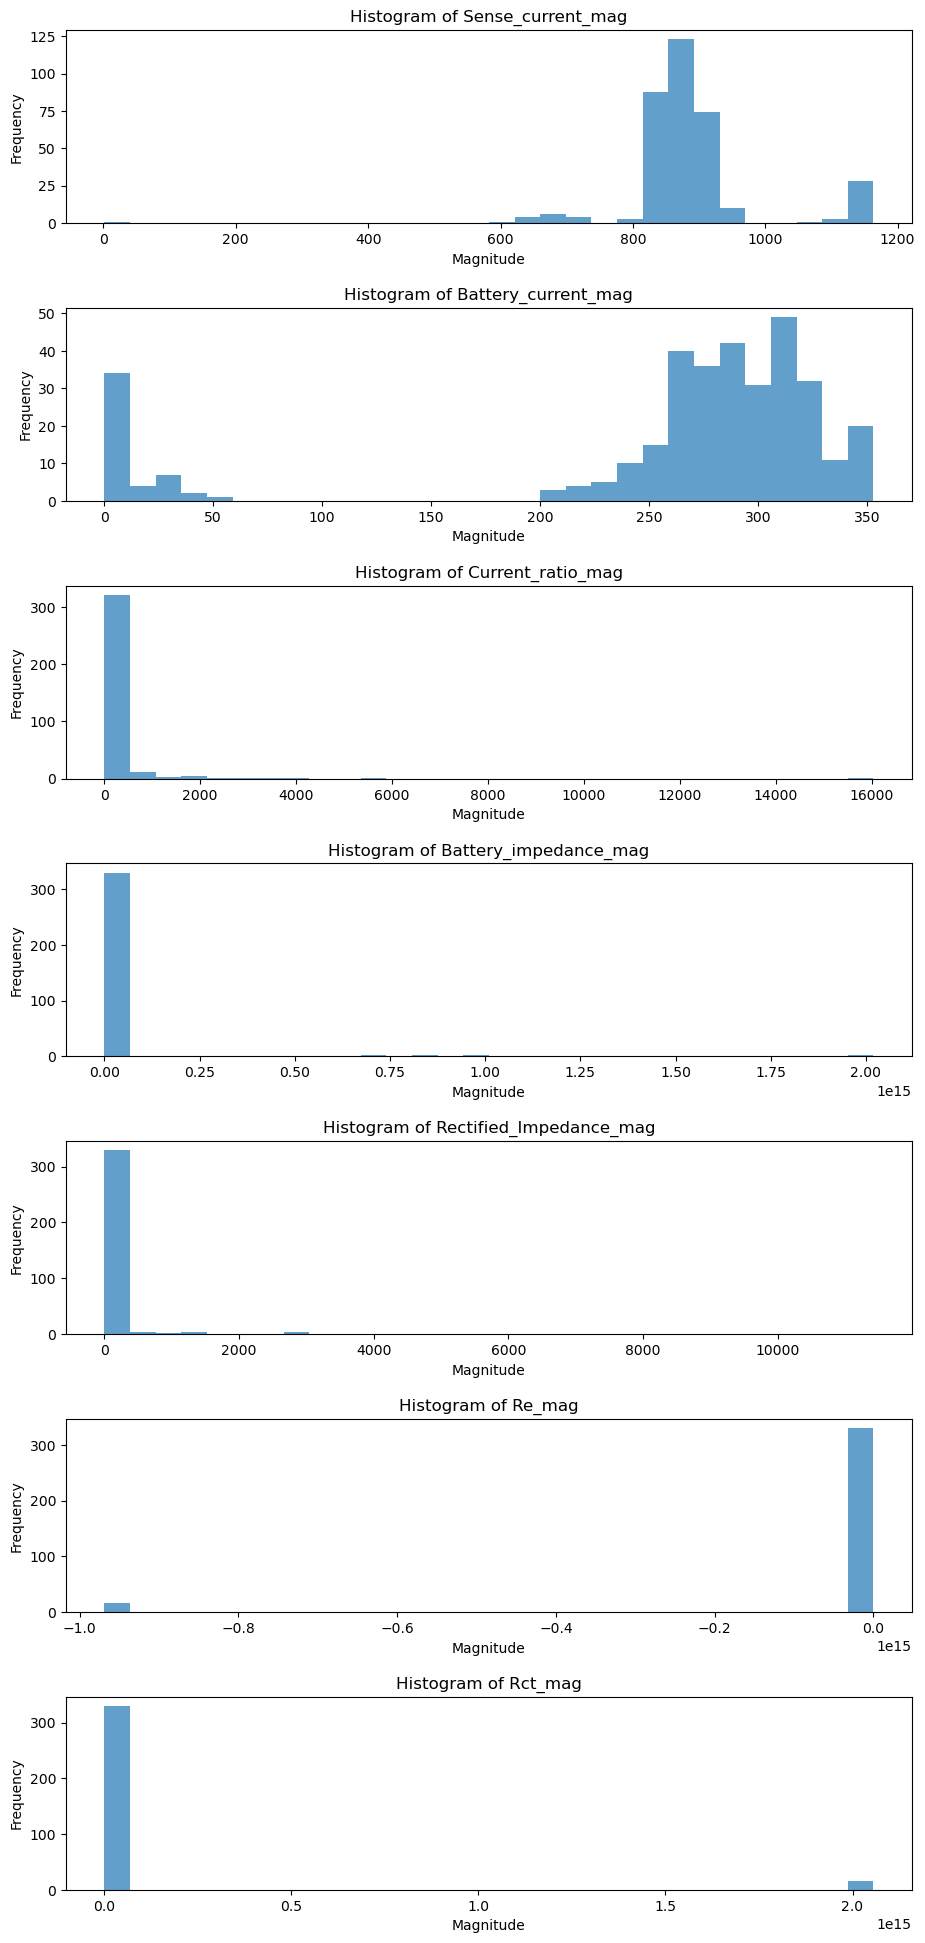

In [26]:
# Filter data for battery B0050
battery_data = impedance_data[impedance_data['battery_id'] == 'B0050']

# Create subplots
fig, axes = plt.subplots(nrows=len(mag_columns), ncols=1, figsize=(10, 20))
fig.tight_layout(pad=4.0)

# Plot histograms
for ax, col in zip(axes, mag_columns):
    ax.hist(battery_data[col], bins=30, alpha=0.7)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Frequency')

plt.show()

In [30]:
# Remove extreme outliers (keep only values within 5 standard deviations)
def remove_outliers(df, columns):
    for col in columns:
        mean = np.log(df[col].replace(0, 1e-10)).mean()
        std = np.log(df[col].replace(0, 1e-10)).std()
        df = df[np.log(df[col].replace(0, 1e-10)).between(mean-5*std, mean+5*std)]
    return df

variances_clean = remove_outliers(variances, ['Re_mag', 'Rct_mag'])

### Does temperature affect variance in impedance metrics?

Since `batteries B0029-B0032 were tested at 43°C` while others were tested at 24°C, and each battery has multiple repeated measurements, we need tests that:

- Compare variance (since our goal is to check consistency).

- Account for dependencies (multiple observations per battery).

- Handle unequal group sizes (fewer batteries at 43°C).

`Permutation Test` (Non-Parametric, Robust) does not assume normality, works well with small sample sizes (only 4 batteries at 43°C).

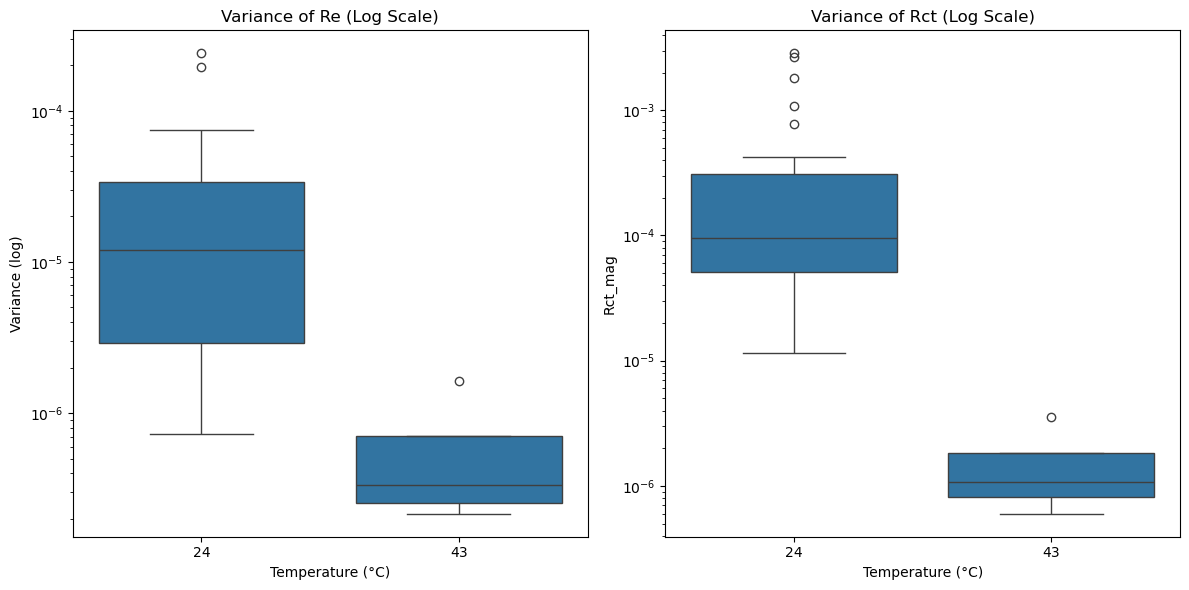

In [33]:
plt.figure(figsize=(12, 6))

# Re_mag variance
plt.subplot(1, 2, 1)
sns.boxplot(data=variances_clean, x='ambient_temperature', y='Re_mag')
plt.yscale('log')
plt.title('Variance of Re (Log Scale)')
plt.ylabel('Variance (log)')
plt.xlabel('Temperature (°C)')

# Rct_mag variance
plt.subplot(1, 2, 2)
sns.boxplot(data=variances_clean, x='ambient_temperature', y='Rct_mag')
plt.yscale('log')
plt.title('Variance of Rct (Log Scale)')
plt.xlabel('Temperature (°C)')

plt.tight_layout()
plt.show()

In [36]:
print("Number of batteries per temperature:")
print(variances_clean['ambient_temperature'].value_counts())

# Separate variances by temperature
group_24 = variances_clean[variances_clean['ambient_temperature'] == 24]
group_43 = variances_clean[variances_clean['ambient_temperature'] == 43]

Number of batteries per temperature:
ambient_temperature
24    28
43     4
Name: count, dtype: int64


#### Permutation Test 

In [38]:
from scipy.stats import permutation_test

def statistic(x, y):
    return np.var(x) / np.var(y)  # Ratio of variances

result = permutation_test(
    (group_24['Re_mag'], group_43['Re_mag']),
    statistic,
    n_resamples=10_000
)
print(f"Permutation p-value for Re_mag: {result.pvalue:.4f}")

result = permutation_test(
    (group_24['Rct_mag'], group_43['Rct_mag']),
    statistic,
    n_resamples=10_000
)
print(f"Permutation p-value for Rct_mag: {result.pvalue:.4f}")

Permutation p-value for Re_mag: 0.0126
Permutation p-value for Rct_mag: 0.0002


`Null Hypothesis (H₀)`: Variances are equal across temperature groups.

`Alternative (H₁)`: Variances are unequal.

The `permutation test` gives significant results (`p < 0.05`).

**Conclusion**:
- Reject the null hypothesis for both metrics (p < 0.05).
- Variances differ significantly between 24°C and 43°C for:

        - Electrolyte resistance (Re_mag).

        - Charge transfer resistance (Rct_mag).

*Permutation test is more reliable* here (than Levene's Test) because it doesn’t assume normality and better handles small samples at 43°C (n=4).



### Does Impedance Variance (Re) Increase in Late-Life Cycles?

Define "early" vs. "late" life cycles as first 20% vs. last 20% of cycles per battery.

In [41]:
impedance_data.head(10)

,filename,ambient_temperature,battery_id,test_id,Sense_current_mag,Battery_current_mag,Current_ratio_mag,Battery_impedance_mag,Rectified_Impedance_mag,Re_mag,Rct_mag
0,00002.csv,24,B0047,1,929.613246,239.533425,3.880933,0.206024,0.176477,0.056058,0.20097
1,00002.csv,24,B0047,1,923.479915,242.962578,3.800914,0.038717,0.170470,0.056058,0.20097
2,00002.csv,24,B0047,1,921.520183,245.983848,3.746263,0.090570,0.162873,0.056058,0.20097
3,00002.csv,24,B0047,1,915.699440,251.246567,3.644625,0.187383,0.151118,0.056058,0.20097
4,00002.csv,24,B0047,1,912.412234,255.151450,3.575963,0.256772,0.142344,0.056058,0.20097
5,00002.csv,24,B0047,1,908.299021,259.566050,3.499298,0.303309,0.133060,0.056058,0.20097
6,00002.csv,24,B0047,1,900.584496,267.648148,3.364808,0.331113,0.124583,0.056058,0.20097
7,00002.csv,24,B0047,1,892.252368,275.154711,3.242730,0.343871,0.114812,0.056058,0.20097
8,00002.csv,24,B0047,1,886.311340,282.067279,3.142198,0.344856,0.109269,0.056058,0.20097
9,00002.csv,24,B0047,1,878.465942,289.249132,3.037056,0.336951,0.101248,0.056058,0.20097


In [42]:
print("Dataset Shape:", impedance_data.shape)
print("\nMissing Values:\n", impedance_data.isnull().sum())

Dataset Shape: (75597, 11)

Missing Values:
 filename                   0
ambient_temperature        0
battery_id                 0
test_id                    0
Sense_current_mag          0
Battery_current_mag        0
Current_ratio_mag          0
Battery_impedance_mag      0
Rectified_Impedance_mag    0
Re_mag                     0
Rct_mag                    0
dtype: int64


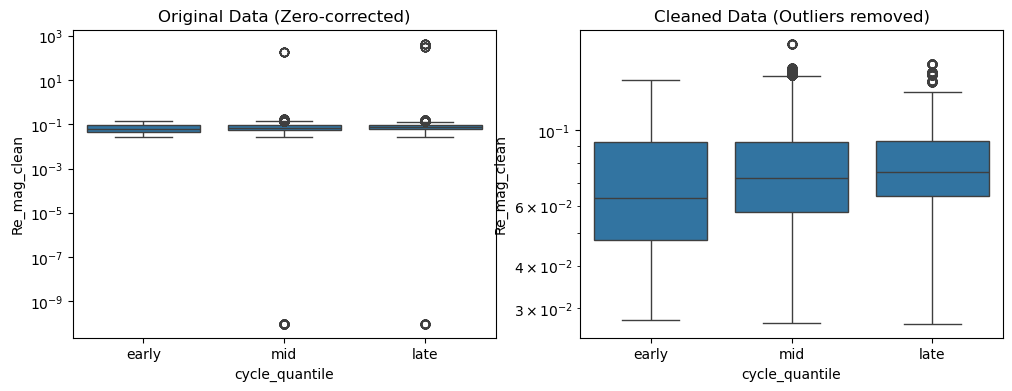

In [44]:
# Prepare the data
impedance_re = impedance_data[['battery_id', 'test_id', 'Re_mag']].dropna()

# Handle zeros/negatives and log transform
impedance_re['Re_mag_clean'] = impedance_re['Re_mag'].clip(lower=1e-10)
impedance_re['log_Re'] = np.log10(impedance_re['Re_mag_clean'])

# Remove outliers
mean_log = impedance_re['log_Re'].mean()
std_log = impedance_re['log_Re'].std()
impedance_clean = impedance_re[
    impedance_re['log_Re'].between(mean_log - 5*std_log, mean_log + 5*std_log)
].copy()

# Add cycle quantile labels to BOTH datasets
for df in [impedance_re, impedance_clean]:
    df['cycle_quantile'] = df.groupby('battery_id')['test_id'].transform(
        lambda x: np.select(
            [x <= x.quantile(0.2), x >= x.quantile(0.8)],
            ['early', 'late'],
            default='mid'
        )
    )


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(data=impedance_re, x='cycle_quantile', y='Re_mag_clean')
plt.yscale('log')
plt.title('Original Data (Zero-corrected)')

plt.subplot(1, 2, 2)
sns.boxplot(data=impedance_clean, x='cycle_quantile', y='Re_mag_clean') 
plt.yscale('log')
plt.title('Cleaned Data (Outliers removed)')
plt.show()

In [45]:
# Calculate cleaning metrics
original_count = impedance_re.shape[0]
cleaned_count = impedance_clean.shape[0]
removed_count = original_count - cleaned_count
removed_pct = removed_count / original_count * 100

# Print formatted summary
print("="*50)
print(f"{'DATA CLEANING SUMMARY':^50}")
print("="*50)
print(f"{'Original dataset:':<30}{original_count:>10,} rows")
print(f"{'Cleaned dataset:':<30}{cleaned_count:>10,} rows")
print(f"{'Rows removed:':<30}{removed_count:>10,} rows ({removed_pct:.2f}%)")
print("="*50)
print(f"{'Retained:':<30}{cleaned_count/original_count:.1%} of original data")
print("="*50)

              DATA CLEANING SUMMARY               
Original dataset:                 75,597 rows
Cleaned dataset:                  75,438 rows
Rows removed:                        159 rows (0.21%)
Retained:                     99.8% of original data


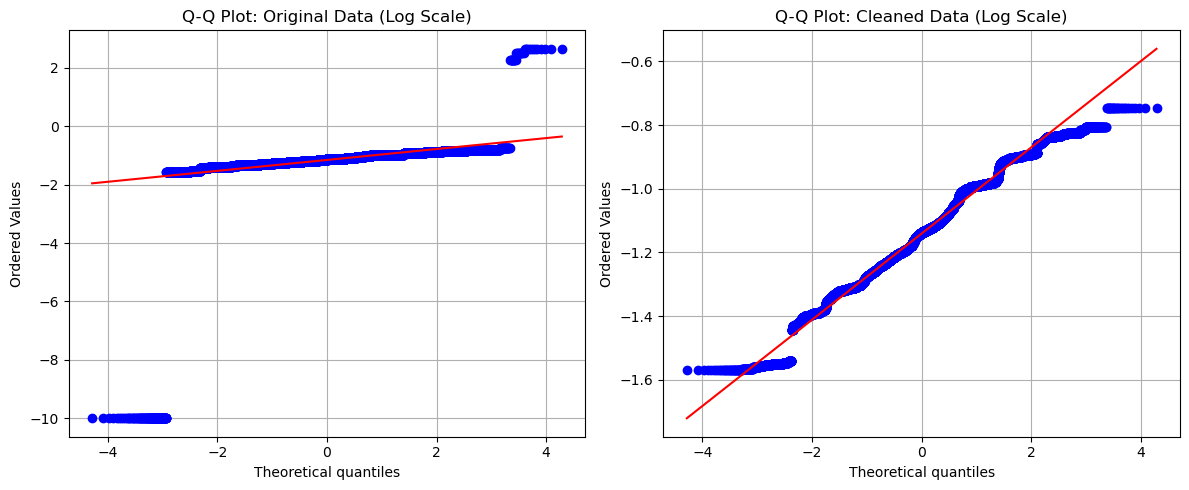

In [46]:
# Create a figure
plt.figure(figsize=(12, 5))

# Subplot 1: Original Data (Log-Transformed)
plt.subplot(1, 2, 1)
stats.probplot(np.log10(impedance_re['Re_mag_clean']), plot=plt)
plt.title('Q-Q Plot: Original Data (Log Scale)')
plt.grid(True)

# Subplot 2: Cleaned Data (Log-Transformed)
plt.subplot(1, 2, 2)
stats.probplot(np.log10(impedance_clean['Re_mag_clean']), plot=plt)
plt.title('Q-Q Plot: Cleaned Data (Log Scale)')
plt.grid(True)

plt.tight_layout()
plt.show()

Levene's test is sensitive to non-normality (even after cleaning, the data has heavy tails) -> `the permutation test is more reliable` here.

#### Permutation Test

In [49]:
early = impedance_clean[impedance_clean['cycle_quantile'] == 'early']['Re_mag_clean']
late = impedance_clean[impedance_clean['cycle_quantile'] == 'late']['Re_mag_clean']

def variance_ratio(x, y):
    return np.var(y) / np.var(x)  # Late/Early variance ratio

result = permutation_test(
    (early, late), 
    variance_ratio, 
    n_resamples=10_000,
    alternative='greater'  # Test if late variance > early
)
print(f"Permutation Test: p = {result.pvalue:.7f}, Ratio = {result.statistic:.7f}x")

Permutation Test: p = 1.0000000, Ratio = 0.7463477x


**Null Hypothesis**: Variances are equal.

**Interpretation**: 
- The p-value of 1.0 means zero evidence that late-cycle variance differs from early-cycle variance.

- The null hypothesis (equal variances) cannot be rejected.

A ratio of 0.75x implies late-cycle variance is 25% lower than early-cycle variance. This contradicts the initial hypothesis that variance increases with aging.

Batteries show more stable impedance (Re_mag) in late cycles, this suggests "healthy" aging that follows a predictable pattern.